# Handlers

Esta tabla contiene la información adicional de las sentencias Try/TryStar.

## 1 - Obtencion de datos

In [1]:
import matplotlib.pyplot as plt
from notebooks_utils import *

full_table = get_data('handlers')

# Table name, features and target.
TABLE_NAME = 'handlers'
TABLE_FEATURES = ['handler__number_of_handlers', 'handler__has_star', 'handler__has_finally', 'handler__has_catch_all', 'handler__average_body_count', 'handler__expertise_level']
TABLE_TARGET = 'handler__expertise_level'

# Load features and target.
X, y = full_table[TABLE_FEATURES], full_table[[TABLE_TARGET]].iloc[:,0]

# Print information about the loaded table.
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

print(f'As we can see the downloaded data contains a total of {X.shape[0]} instances. For each instance we have {X.shape[1]} attributes.')

2024-07-04 18:53:11.535434 Data cache files found ...
2024-07-04 18:53:11.538438 Data cache files successfully loaded!!
Features shape: (15756, 6)
Target shape: (15756,)
As we can see the downloaded data contains a total of 15756 instances. For each instance we have 6 attributes.


## 2 - Exploracion de datos

Una vez tenemos nuestra tabla en un dataframe el siguiente paso es explorarla para ver qué tipo de información contiene.

In [2]:
print(X.info())
print('=============')
print(y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15756 entries, 0 to 15755
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   handler__number_of_handlers  15756 non-null  int64  
 1   handler__has_star            15756 non-null  bool   
 2   handler__has_finally         15756 non-null  bool   
 3   handler__has_catch_all       15756 non-null  bool   
 4   handler__average_body_count  15756 non-null  float64
 5   handler__expertise_level     15756 non-null  object 
dtypes: bool(3), float64(1), int64(1), object(1)
memory usage: 415.6+ KB
None
<class 'pandas.core.series.Series'>
RangeIndex: 15756 entries, 0 to 15755
Series name: handler__expertise_level
Non-Null Count  Dtype 
--------------  ----- 
15756 non-null  object
dtypes: object(1)
memory usage: 123.2+ KB
None


Cómo podemos ver la tabla está compuesta por 2 variables numéricas, 3 de tipo boleano  y una de tipo objeto.

### 2.1 - Equilibrado de clases

In [3]:
instances_for_class_low = len(full_table[full_table[TABLE_TARGET] == "BEGINNER"])
instances_for_class_high = len(full_table[full_table[TABLE_TARGET] == "EXPERT"])

print(f"The dataset contains {instances_for_class_low/len(full_table)*100:.4}% instances for BEGINNER class and {instances_for_class_high/len(full_table)*100:.4}% for EXPERT class.")

The dataset contains 56.82% instances for BEGINNER class and 43.18% for EXPERT class.


### 2.2 - Valores Nulos 
Miramos si alguna de las variables que contiene la tabla contiene algún valor que sea nulo.

In [4]:
X.isnull().sum()

handler__number_of_handlers    0
handler__has_star              0
handler__has_finally           0
handler__has_catch_all         0
handler__average_body_count    0
handler__expertise_level       0
dtype: int64

Aunque una columna no contenga valores nulos podría ser que contenga valores vacíos. Si los hubiese la siguiente función los mostraría.

In [5]:
print_empty_cols(X)

handler__number_of_handlers
---------------------------
0 instancias no tienen un valor para la columna handler__number_of_handlers


handler__has_star
-----------------
0 instancias no tienen un valor para la columna handler__has_star


handler__has_finally
--------------------
0 instancias no tienen un valor para la columna handler__has_finally


handler__has_catch_all
----------------------
0 instancias no tienen un valor para la columna handler__has_catch_all


handler__average_body_count
---------------------------
0 instancias no tienen un valor para la columna handler__average_body_count


handler__expertise_level
------------------------
0 instancias no tienen un valor para la columna handler__expertise_level




### 2.3 - Describimos los valores de las variables de la tabla.

In [6]:
np.transpose(X.describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int']))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
handler__number_of_handlers,15756.0,NaN,NaN,NaN,0.99378,0.46149,0.0,1.0,1.0,1.0,9.0
handler__has_star,15756,1,False,15756,NaN,NaN,NaN,NaN,NaN,NaN,NaN
handler__has_finally,15756,2,False,14394,NaN,NaN,NaN,NaN,NaN,NaN,NaN
handler__has_catch_all,15756,2,False,14905,NaN,NaN,NaN,NaN,NaN,NaN,NaN
handler__average_body_count,15756.0,NaN,NaN,NaN,1.281047,0.866553,0.0,1.0,1.0,1.0,15.0
handler__expertise_level,15756,2,BEGINNER,8953,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### IMPORTANTE
Hay try con un numero medio de sentencias en los bodies de 0? Un try vacio? La indentacion de python suele impedirlo

Vamos a discretizar las variables numericas, agrupando conjuntos de valores en categorias, para hacer un análisis de los datos. Para cada variable es necesaario ver la distribucion de lo valores para hacer los bins (categorias).

In [7]:
# DISCRETIZATION
X_copy = X.copy()

discretized_columns = {
    "handler__number_of_handlers": [(0.0, 0.0), (1.0, 1.0), (1.0, inf)],  # min: 0.0 max: 9.0 
    "handler__average_body_count": [(0.0, 1.0), (1.0, 2.0), (2.0, inf)],  # min: 0.0 max: 11.0 
}

discretize_columns(X_copy, discretized_columns)
    
# SINGLE FEATURE
print("--- SINGLE FEATURE ---")
print(get_statistics(X_copy, ['handler__number_of_handlers'], 10))
print(get_statistics(X_copy, ['handler__average_body_count'], 10))
print(get_statistics(X_copy, ['handler__has_star'], 10))
print(get_statistics(X_copy, ['handler__has_finally'], 10))
print(get_statistics(X_copy, ['handler__has_catch_all'], 10))

# 2 FEATURES
print("--- TWO FEATURES ---")
#print(get_statistics(X_copy, ['import__average_imported_modules', 'import__module_imports_pct'], 10))

# 3 FEATURES
print("--- THREE FEATURES ---")
#print(get_statistics(X_copy, ['program__has_sub_dirs_with_code', 'program__has_packages', 'program__has_code_root_package'], 10))

--- SINGLE FEATURE ---
handler__number_of_handlers  count  percentage
                  [1.0_1.0]  13933   88.429805
                  [0.0_0.0]   1123    7.127444
                  [1.0_inf]    700    4.442752

handler__average_body_count  count  percentage
                  [1.0_2.0)  10972   69.636964
                  [2.0_inf]   3661   23.235593
                  [0.0_1.0)   1123    7.127444

 handler__has_star  count  percentage
             False  15756       100.0

 handler__has_finally  count  percentage
                False  14394   91.355674
                 True   1362    8.644326

 handler__has_catch_all  count  percentage
                  False  14905   94.598883
                   True    851    5.401117

--- TWO FEATURES ---
--- THREE FEATURES ---


In [8]:
def normalize_datatypes(X:pd.DataFrame, y:pd.Series) -> (pd.DataFrame, pd.Series, [str]):
    X = pd.get_dummies(X)
    X = X.astype('float32')
    y = y.apply(lambda value: 0 if value == "BEGINNER" else 1) # EXPERT will be 1 and BEGINNER will be 0.
    y = y.astype('float32')
    columns_names = X.columns.tolist()
    return X, y, columns_names

X, y, TABLE_FEATURES = normalize_datatypes(X, y)
# Print information about the loaded table
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

Features shape: (15756, 7)
Target shape: (15756,)


#### Muestra la matriz de correlación de Spearman entre las variables de la tabla.

<Axes: >

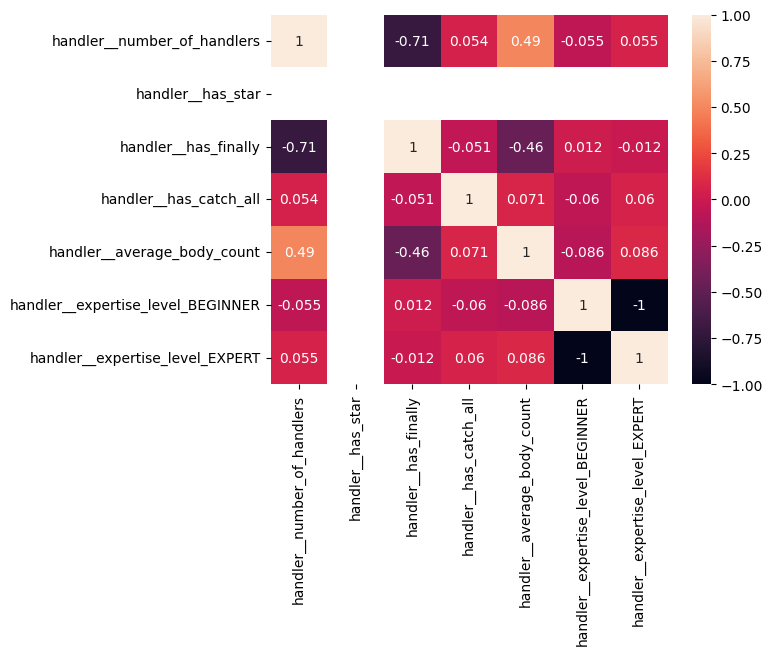

In [9]:
sns.heatmap(X.corr(method='spearman'), annot=True)

## 3 - Detección de valores atípicos (outliers)
## Univariate
## Analisis detallado de variables
Para cada una de las 5 variable (2 numericas y 3 booleanas) se hara un analisis detallado

### Variable number_of_handlers (1/5)
Esta variable es de tipo numérica y nos indica el número de clausulas except en la sentencia Try. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 0 - 9. Con una media de 0.99.

<Axes: ylabel='handler__number_of_handlers'>

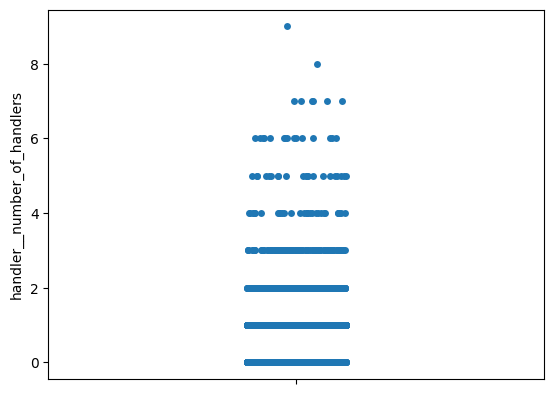

In [10]:
sns.stripplot(X['handler__number_of_handlers'])

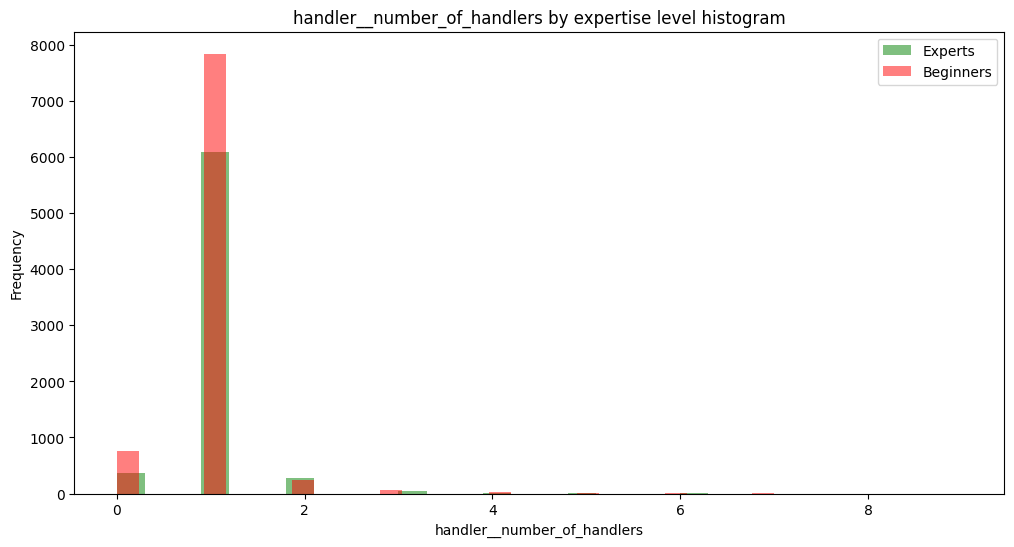

In [11]:
print_histogram(X, 'handler__number_of_handlers', 'handler__expertise_level', bins=30, include_all=False)

In [12]:
print_outliers_for_df_column(X, 'handler__number_of_handlers')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.3888888888888889
Rango valores atípicos extremos (Tukey): [1.0,1.0]
Rango valores atípicos leves (Tukey): [1.0,1.0]
Rango valores atípicos extremos (Fixed BoxPlot): [1.0,1.0]
-3.0IQR: 1123 instancias tienen un valor para handler__number_of_handlers inferior a 1.0 (Q1-3*IQR) para handler__number_of_handlers. Representando un 7.127% del total de instancias.
-1.5IQR: 1123 instancias tienen un valor para handler__number_of_handlers inferior a 1.0 (Q1-1.5*IQR) para handler__number_of_handlers. Representando un 7.127% del total de instancias.
+1.5IQR: 700 instancias tienen un valor para handler__number_of_handlers superior a 1.0 (Q3+1.5*IQR) para handler__number_of_handlers. Representando un 4.443% del total de instancias.
+3.0IQR: 700 instancias tienen un valor para handler__number_of_handlers superior a 1.0 (Q3-3*IQR) para handler__number_of_handlers. Representando un 4.443% del total de instancias.
L: 1123 instancias tienen un va

Describimos los valores de las variables de la tabla, cuando el valor de la variable es mayor que 1 o menor que 1 (Todos los umbrales son 1)

In [13]:
X[(X['handler__number_of_handlers'] > 1) | (X['handler__number_of_handlers'] < 1)].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,handler__number_of_handlers,handler__has_star,handler__has_finally,handler__has_catch_all,handler__average_body_count,handler__expertise_level_BEGINNER,handler__expertise_level_EXPERT
count,1823.000000,1823.0,1823.000000,1823.000000,1823.000000,1823.000000,1823.000000
mean,0.946242,0.0,0.636862,0.023039,0.605688,0.611081,0.388919
std,1.356112,0.0,0.481036,0.150068,0.954718,0.487639,0.487639
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.0,1.000000,0.000000,0.000000,1.000000,0.000000
75%,2.000000,0.0,1.000000,0.000000,1.000000,1.000000,1.000000
max,9.000000,0.0,1.000000,1.000000,9.500000,1.000000,1.000000


### Variable average_body_count (2/5)
Esta variable representa el número medio de sentencias en los cuerpos del try y los except. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 0 - 15. Con una media de 1.28.

<Axes: ylabel='handler__average_body_count'>

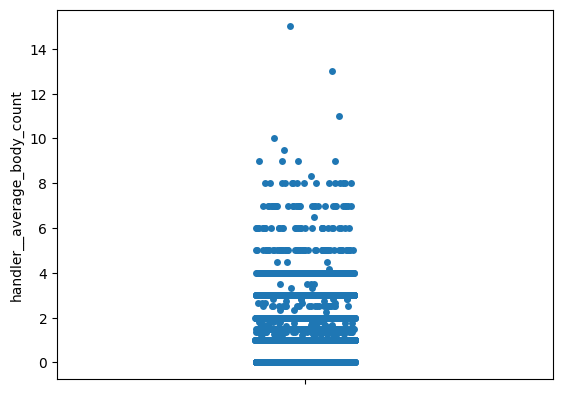

In [14]:
sns.stripplot(X['handler__average_body_count'])

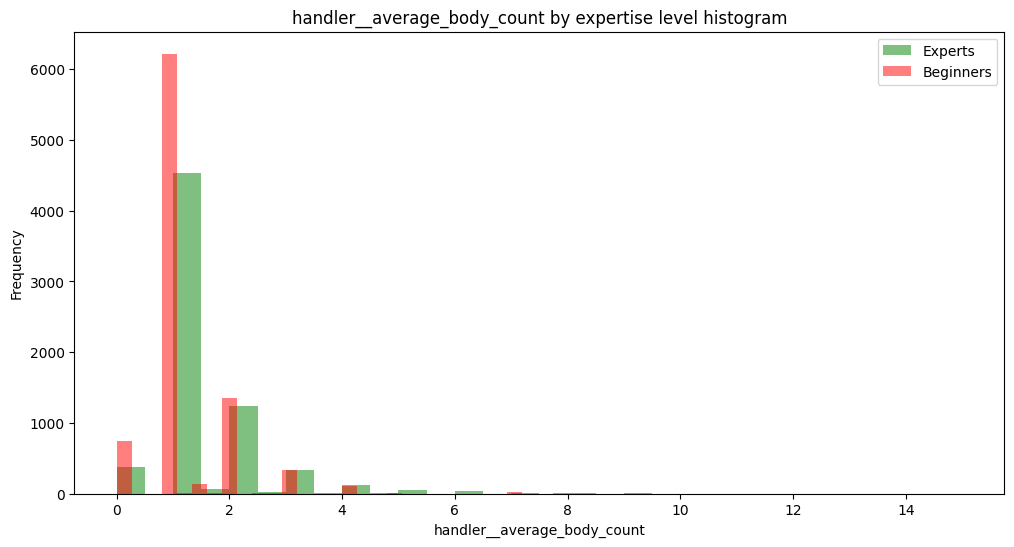

In [15]:
print_histogram(X, 'handler__average_body_count', 'handler__expertise_level', bins=30, include_all=False)

In [16]:
print_outliers_for_df_column(X, 'handler__average_body_count')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.9238913967973881
Rango valores atípicos extremos (Tukey): [1.0,1.0]
Rango valores atípicos leves (Tukey): [1.0,1.0]
Rango valores atípicos extremos (Fixed BoxPlot): [1.0,1.0]
-3.0IQR: 1123 instancias tienen un valor para handler__average_body_count inferior a 1.0 (Q1-3*IQR) para handler__average_body_count. Representando un 7.127% del total de instancias.
-1.5IQR: 1123 instancias tienen un valor para handler__average_body_count inferior a 1.0 (Q1-1.5*IQR) para handler__average_body_count. Representando un 7.127% del total de instancias.
+1.5IQR: 3890 instancias tienen un valor para handler__average_body_count superior a 1.0 (Q3+1.5*IQR) para handler__average_body_count. Representando un 24.69% del total de instancias.
+3.0IQR: 3890 instancias tienen un valor para handler__average_body_count superior a 1.0 (Q3-3*IQR) para handler__average_body_count. Representando un 24.69% del total de instancias.
L: 1123 instancias tienen un 

In [17]:
X[(X['handler__average_body_count'] > 1) | (X['handler__average_body_count'] < 1)].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,handler__number_of_handlers,handler__has_star,handler__has_finally,handler__has_catch_all,handler__average_body_count,handler__expertise_level_BEGINNER,handler__expertise_level_EXPERT
count,5013.000000,5013.0,5013.000000,5013.000000,5013.000000,5013.000000,5013.000000
mean,0.900658,0.0,0.245562,0.057451,1.883337,0.545183,0.454817
std,0.727486,0.0,0.430463,0.232725,1.352158,0.498004,0.498004
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.0,0.000000,0.000000,1.500000,0.000000,0.000000
50%,1.000000,0.0,0.000000,0.000000,2.000000,1.000000,0.000000
75%,1.000000,0.0,0.000000,0.000000,2.000000,1.000000,1.000000
max,9.000000,0.0,1.000000,1.000000,15.000000,1.000000,1.000000


### IMPORTANTE
Puede parecer imposible que haya algun handler con 0 como average body count. Esto se debe a que en Python debido a la indentacion no se permite hacer:
try:
    ...
except:

a = 1 (fuera del except)

Que estos valores sean posibles es debido a la presencia de try con unicamente una cláusula finally.

### Variable has_star (3/5)
Esta variable es de tipo booleano y representa es una sentencia del tipo TryStar.

<Axes: xlabel='handler__has_star', ylabel='Count'>

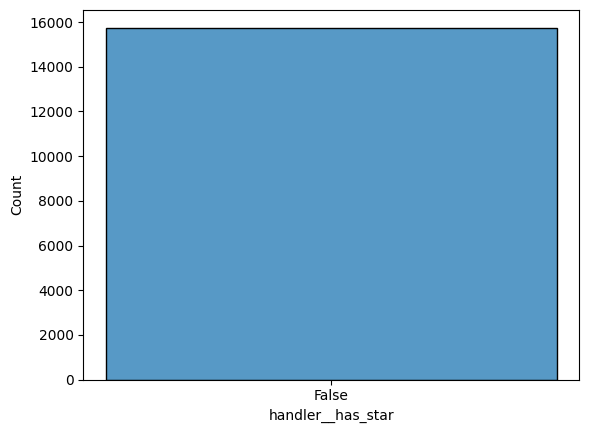

In [18]:
plt.xticks([0, 1], ['False', 'True'])
sns.histplot(X['handler__has_star'], discrete=True)

In [19]:
num_true_values = len(X[X['handler__has_star'] == True])
num_false_values = len(X[X['handler__has_star'] == False])
std = X['handler__has_star'].std()
freq_true = len(X[X['handler__has_star'] == True]) / len(X['handler__has_star'])
freq_false = len(X[X['handler__has_star'] == False]) / len(X['handler__has_star'])
print(f'La variable has_star contiene {num_true_values} valores verdaderos y {num_false_values} valores falsos. Y, la desviación típica es de {std}')
print(f'La frecuencia con la que programa puede tener la variable has_star a True es {freq_true}.')
print(f'La frecuencia con la que programa puede tener la variable has_star a False es {freq_false}.')

La variable has_star contiene 0 valores verdaderos y 15756 valores falsos. Y, la desviación típica es de 0.0
La frecuencia con la que programa puede tener la variable has_star a True es 0.0.
La frecuencia con la que programa puede tener la variable has_star a False es 1.0.


In [20]:
possible_values = [True, False]
print_frequency_anal_for_cat_var(X, 'handler__has_star', possible_values)

La variable handler__has_star contiene 2 valores distintos.
El umbral de outlier es de 0.1%
La variable handler__has_star toma el valor de 0.0 en un 100.0% de los items.
La variable handler__has_star toma el valor de True en un 0.0% de los items. [OUTLIER]


### IMPORTANTE 

No hay ningun try del tipo TryStar por lo que ninguna entrada toma el valor True para has_star

### Variable has_catch_all (4/5)
Esta variable es de tipo booleano y representa si el try tiene un except all.

<Axes: xlabel='handler__has_catch_all', ylabel='Count'>

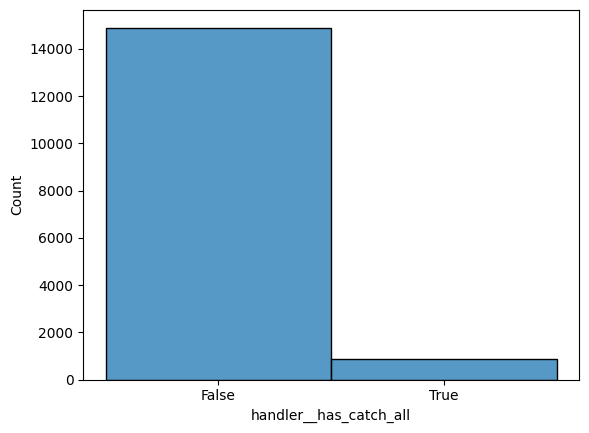

In [21]:
plt.xticks([0, 1], ['False', 'True'])
sns.histplot(X['handler__has_catch_all'], discrete=True)

In [22]:
num_true_values = len(X[X['handler__has_catch_all'] == True])
num_false_values = len(X[X['handler__has_catch_all'] == False])
std = X['handler__has_catch_all'].std()
freq_true = len(X[X['handler__has_catch_all'] == True]) / len(X['handler__has_catch_all'])
freq_false = len(X[X['handler__has_catch_all'] == False]) / len(X['handler__has_catch_all'])
print(f'La variable has_catch_all contiene {num_true_values} valores verdaderos y {num_false_values} valores falsos. Y, la desviación típica es de {std}')
print(f'La frecuencia con la que programa puede tener la variable has_catch_all a True es {freq_true}.')
print(f'La frecuencia con la que programa puede tener la variable has_catch_all a False es {freq_false}.')

La variable has_catch_all contiene 851 valores verdaderos y 14905 valores falsos. Y, la desviación típica es de 0.22604691982269287
La frecuencia con la que programa puede tener la variable has_catch_all a True es 0.05401117034780401.
La frecuencia con la que programa puede tener la variable has_catch_all a False es 0.945988829652196.


In [23]:
possible_values = [True, False]
print_frequency_anal_for_cat_var(X, 'handler__has_catch_all', possible_values)

La variable handler__has_catch_all contiene 2 valores distintos.
El umbral de outlier es de 0.1%
La variable handler__has_catch_all toma el valor de 0.0 en un 94.6% de los items.
La variable handler__has_catch_all toma el valor de 1.0 en un 5.401% de los items.


In [24]:
X[X['handler__has_catch_all'] == True].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])


,handler__number_of_handlers,handler__has_star,handler__has_finally,handler__has_catch_all,handler__average_body_count,handler__expertise_level_BEGINNER,handler__expertise_level_EXPERT
count,851.000000,851.0,851.000000,851.0,851.000000,851.000000,851.000000
mean,1.064630,0.0,0.027027,1.0,1.528496,0.444183,0.555817
std,0.355537,0.0,0.162258,0.0,1.134448,0.497167,0.497167
min,1.000000,0.0,0.000000,1.0,1.000000,0.000000,0.000000
25%,1.000000,0.0,0.000000,1.0,1.000000,0.000000,0.000000
50%,1.000000,0.0,0.000000,1.0,1.000000,0.000000,1.000000
75%,1.000000,0.0,0.000000,1.0,2.000000,1.000000,1.000000
max,8.000000,0.0,1.000000,1.0,15.000000,1.000000,1.000000


### Variable has_finally (5/5)
Esta variable es de tipo booleano y representa si el Try tiene la clausula finally.

<Axes: xlabel='handler__has_finally', ylabel='Count'>

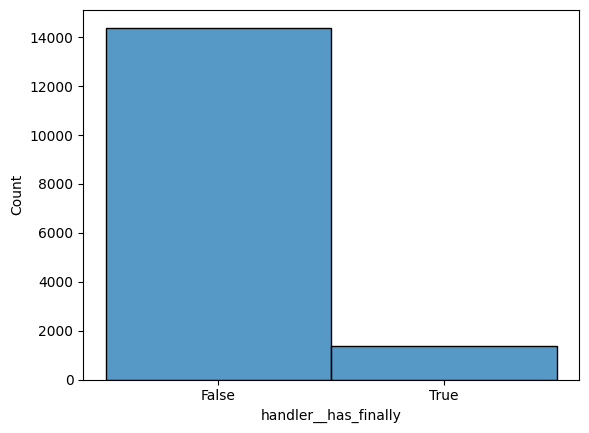

In [25]:
plt.xticks([0, 1], ['False', 'True'])
sns.histplot(X['handler__has_finally'], discrete=True)

In [26]:
num_true_values = len(X[X['handler__has_finally'] == True])
num_false_values = len(X[X['handler__has_finally'] == False])
std = X['handler__has_finally'].std()
freq_true = len(X[X['handler__has_finally'] == True]) / len(X['handler__has_finally'])
freq_false = len(X[X['handler__has_finally'] == False]) / len(X['handler__has_finally'])
print(f'La variable has_finally contiene {num_true_values} valores verdaderos y {num_false_values} valores falsos. Y, la desviación típica es de {std}')
print(f'La frecuencia con la que programa puede tener la variable has_finally a True es {freq_true}.')
print(f'La frecuencia con la que programa puede tener la variable has_finally a False es {freq_false}.')

La variable has_finally contiene 1362 valores verdaderos y 14394 valores falsos. Y, la desviación típica es de 0.2810263931751251
La frecuencia con la que programa puede tener la variable has_finally a True es 0.08644325971058645.
La frecuencia con la que programa puede tener la variable has_finally a False es 0.9135567402894136.


In [27]:
possible_values = [True, False]
print_frequency_anal_for_cat_var(X, 'handler__has_finally', possible_values)

La variable handler__has_finally contiene 2 valores distintos.
El umbral de outlier es de 0.1%
La variable handler__has_finally toma el valor de 0.0 en un 91.36% de los items.
La variable handler__has_finally toma el valor de 1.0 en un 8.644% de los items.


In [28]:
X[X['handler__has_finally'] == True].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,handler__number_of_handlers,handler__has_star,handler__has_finally,handler__has_catch_all,handler__average_body_count,handler__expertise_level_BEGINNER,handler__expertise_level_EXPERT
count,1362.000000,1362.0,1362.0,1362.000000,1362.000000,1362.000000,1362.000000
mean,0.223935,0.0,1.0,0.016887,0.316459,0.587372,0.412629
std,0.590582,0.0,0.0,0.128895,0.850125,0.492488,0.492488
min,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.0,1.0,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.0,1.0,0.000000,0.000000,1.000000,1.000000
max,8.000000,0.0,1.0,1.000000,10.000000,1.000000,1.000000


## Multivariate

Isolation forest algorithm

In [29]:
from sklearn.ensemble import  IsolationForest

CONTAMINATION_FACTOR = 0.0012
isof_model = IsolationForest(contamination=CONTAMINATION_FACTOR, random_state=0)
isof_prediction = isof_model.fit_predict(X.values)
mask = isof_prediction == -1
full_table.loc[X.index[mask]]

,handler__number_of_handlers,handler__has_finally,handler__has_catch_all,handler__average_body_count,handler__has_star,handler__expertise_level
93,6,True,False,2.833333,False,BEGINNER
9266,3,False,False,9.000000,False,EXPERT
9317,3,True,False,8.333333,False,EXPERT
9319,3,True,True,2.000000,False,EXPERT
9485,5,True,False,1.600000,False,EXPERT
9662,3,True,False,5.000000,False,EXPERT
9728,1,False,True,9.000000,False,EXPERT
9997,3,True,True,1.000000,False,EXPERT
9998,8,True,True,2.750000,False,EXPERT
11043,1,False,True,13.000000,False,EXPERT


### IMPORTANTE
Hay que analizar los 16 outliers detectados

In [30]:
# Outliers
np.transpose(X[mask].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int']))

,count,mean,std,min,25%,50%,75%,max
handler__number_of_handlers,16.0,3.375000,2.028957,1.0,2.500,3.000000,4.25,8.0
handler__has_star,16.0,0.000000,0.000000,0.0,0.000,0.000000,0.00,0.0
handler__has_finally,16.0,0.687500,0.478714,0.0,0.000,1.000000,1.00,1.0
handler__has_catch_all,16.0,0.437500,0.512348,0.0,0.000,0.000000,1.00,1.0
handler__average_body_count,16.0,5.636458,4.463864,1.0,2.375,3.583333,9.00,15.0
handler__expertise_level_BEGINNER,16.0,0.062500,0.250000,0.0,0.000,0.000000,0.00,1.0
handler__expertise_level_EXPERT,16.0,0.937500,0.250000,0.0,1.000,1.000000,1.00,1.0


In [31]:
# Non-Outliers
np.transpose(X[~mask].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int']))

,count,mean,std,min,25%,50%,75%,max
handler__number_of_handlers,15740.0,0.991360,0.451105,0.0,1.0,1.0,1.0,9.0
handler__has_star,15740.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
handler__has_finally,15740.0,0.085832,0.280125,0.0,0.0,0.0,0.0,1.0
handler__has_catch_all,15740.0,0.053621,0.225276,0.0,0.0,0.0,0.0,1.0
handler__average_body_count,15740.0,1.276619,0.844620,0.0,1.0,1.0,1.0,11.0
handler__expertise_level_BEGINNER,15740.0,0.568742,0.495268,0.0,0.0,1.0,1.0,1.0
handler__expertise_level_EXPERT,15740.0,0.431258,0.495268,0.0,0.0,0.0,1.0,1.0
